In [808]:
%matplotlib inline

import os 
import sys 
import time
import hashlib

from datetime  import datetime 

import numpy as np 
import pandas as pd

from scipy import stats
from scipy.stats import itemfreq
from scipy import linalg
import scipy.cluster.hierarchy as sch
import fastcluster as fc 

from sklearn.decomposition import PCA
from sklearn.decomposition import ProjectedGradientNMF

from sklearn.cluster import KMeans
from sklearn import mixture
from sklearn import svm
from sklearn import preprocessing
from sklearn.neighbors import KDTree
import statsmodels.api as sm 


import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

import seaborn as sns 
sns.set_style("whitegrid")
sns.set(rc={"figure.figsize": (14, 6)})

import IPython
from IPython.display import display

import preprocess as prep
import dataformat as dtf

In [1002]:
#data_fin='../data/raw/test'
# data_fin='../data/raw/httpget-H1march2014.csv'
# data_fout='../data/preprocessed/httpget-H1march2014_expanded.csv'
data_fin='../data/raw/udpjitter-H1april2014.csv'
data_fout='../data/preprocessed/udpjitter-H1april2014_exp.csv'
meta_fin = '../data/metadata/metadata-anon.csv'
exclude_fin = '../data/metadata/probes_on_a_trial.csv'
url_to_ip = '../data/metadata/url_to_ip.csv'
reserved_ips = '../data/metadata/ipaddr_reserved.csv'


In [1003]:
# create enrinched data  
X = prep.prepare_rawdata(data_fin, 
                         fout=data_fout, 
                         metadata=meta_fin, 
                         exclude=exclude_fin,
                         url_to_ip = url_to_ip,
                         drop_reserved = reserved_ips
                        )

drop reserved
X=(3409468, 24)  dropped=0
save ../data/preprocessed/udpjitter-H1april2014_exp.csv


In [1004]:
X.head(4)

,unit_id,dtime,target,month,day,hour,minute,packet_size,stream_rate,duration,...,jitter_up,jitter_down,latency,successes,failures,location_id,ranNode,apNode,hubType,headlineSpeed
444161,33282,2014-04-01 00:00:02,173.234.235.106,4,1,0,0,160,64000,10044129,...,307,215,93009,1,0,60180,1,9,5,4
380250,156280,2014-04-01 00:00:02,81.147.49.140,4,1,0,0,160,64000,10043048,...,184,152,6186,1,0,224555,1,6,9,4
140413,484532,2014-04-01 00:00:03,81.147.49.140,4,1,0,0,160,64000,0,...,0,0,0,0,1,631016,5,7,9,2
376477,165816,2014-04-01 00:00:03,81.147.49.140,4,1,0,0,160,64000,10044338,...,445,357,27259,1,0,326861,5,8,9,2


In [1122]:
#  failures  
nosent = X[X['packets_up_sent'] == 0]
# drop no sends .. 
Y =  X.drop (nosent.index)
fails = Y[ Y['failures'] == 1]


#X.sort(inplace=1)
# #y[['jitter_up', 'jitter_down']].plot(lw=3, alpha=.4)
g_uid_trg = Y.groupby([ 'unit_id','target'])
g_uid = Y.groupby([ 'unit_id'])
g_trg = Y.groupby([ 'target'])

g_uid_trg_d = dict(list( g_uid_trg ))
g_uid_trg_keys = g_uid_trg_d.keys()

g_uid_d = dict(list( g_uid ))
g_uid_keys = g_uid_d.keys()

g_trg_d = dict(list( g_trg ))
g_trg_keys = g_trg_d.keys()

# print X_g_uid[['successes','failures']].sum() 
# print '------'

print g_trg[['successes','failures']].sum() 
print '------'

# print X_g_uid_trg[['successes','failures']].sum() 
# print '------'


                 successes  failures
target                              
108.62.233.154      212159       155
173.208.58.34       212377       138
173.234.234.170     212318       117
173.234.235.106     213139       135
46.17.56.234        213912       223
46.17.56.235        212645       215
77.75.104.26        213338       231
77.75.104.27        212407       185
81.147.49.140       821168      1158
81.147.49.141       825662      1282
------


In [1123]:

unitfails  = itemfreq(fails['unit_id'])
tarfails  = itemfreq(fails['target'])

_uf = np.unique (unitfails[:,0])
_ux = np.unique ( X['unit_id'] )
print '# failing units %d / %s' % (_uf.shape[0], _ux.shape[0])

_uf = np.unique (tarfails[:,0])
_ux = np.unique ( X['target'] )
print '# failing targets %d / %s' % (_uf.shape[0], _ux.shape[0])


#zscore = lambda x: (x - x.mean()) / x.std()

# for k in g_trg_keys [:3]:
#     z = g_trg_d[k]
#     #fig, ax = prep._init_axes_()
#     print len(z)
#     #display (z[ z['failures'] == 1  ])
#         x.head(4)
#     z[['jitter_up', 'jitter_down']].plot(lw=0, marker='.',
#                                          alpha=.3, ax=ax)    
#     x = z[ z['failures'] == 1 ][['jitter_up', 
#                              'jitter_down']]
#     #.apply(lambda x: np.log(1+x))
    
#     x.plot(lw=0, marker='o',  ms=14, mew=3,   alpha=.3,  ax=ax)
#     #ax.set_yscale('log')

# display( z[ z['failures'] == 1 ].sort(['location_id']) ) #[[ 'unit_id']] 

# failing units 502 / 2735
# failing targets 10 / 10


In [1018]:
print len ( np.unique(fails['unit_id'])), 
print len (np.unique(fails['location_id'])) 

502 504


In [1095]:
f_uid = fails.groupby([ 'unit_id'])
s = f_uid[['failures']].sum()
# sort by num of failires 
idx = np.argsort(s.values.T[0])[::-1]
idx = s.iloc[idx]#['unit_id']#.index.values
fails_s = idx.index.values
#print idx
#np.argsort(s.values)[::-1]
f = f_uid.get_group(fails_s[0])
g = g_uid.get_group(fails_s[0])

_z1 = itemfreq(f['target'])
_z2 = itemfreq(g['target'])
z = np.zeros(_z1.shape) 

print _z1
print '--'
print _z1



[['108.62.233.154' 29]
 ['173.208.58.34' 27]
 ['173.234.234.170' 25]
 ['173.234.235.106' 22]
 ['46.17.56.234' 42]
 ['46.17.56.235' 26]
 ['77.75.104.26' 36]
 ['77.75.104.27' 21]
 ['81.147.49.140' 143]
 ['81.147.49.141' 124]]
--
[['108.62.233.154' 29]
 ['173.208.58.34' 27]
 ['173.234.234.170' 25]
 ['173.234.235.106' 22]
 ['46.17.56.234' 42]
 ['46.17.56.235' 26]
 ['77.75.104.26' 36]
 ['77.75.104.27' 21]
 ['81.147.49.140' 143]
 ['81.147.49.141' 124]]


495 1085


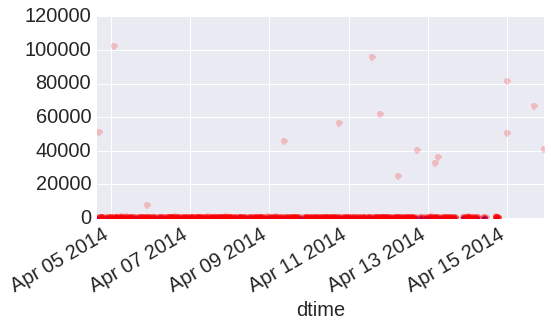

In [1157]:
q = g.sort('dtime')
q.index=q['dtime'] #, columns='jitter_up', )

z = q[q['failures']==1].index
#index='date', columns='variable', values='value'
# x = q['jitter_down']
#u = (q['jitter_up'] - q['jitter_up'].mean()) / q['jitter_up'].std()
d = q['jitter_down'] #(q['jitter_down'] - q['jitter_down'].mean()) / q['jitter_down'].std()

u = u[u>1.1]
#d = d[d>2]

w = d[z]
y = u[z]

u.plot(lw=0, marker='.', c='b', alpha=.8)
d.plot(lw=0, marker='.', c='g', alpha=.8)
w.plot(lw=0, marker='o', c='r', alpha=.2)
y.plot(lw=0, marker='o', c='r', alpha=.2)

#print x[x['failures']==1]
print len(z), len(x)

In [1107]:
len(fails.index), np.unique(fails.index).shape 

(3839, (3839,))

In [445]:
pairs.groups.keys()
z = pairs.get_group((14847, '108.62.233.154'))
z[z['failures']  == 1 ]

In [465]:
nosent = X[X['packets_up_sent'] == 0]
print len(nosent)
nosent.describe()

Y = X.drop( nosent.index)
pairs = Y.groupby([ 'unit_id','target'])
print pairs[['successes','failures']].sum() 

#print 
#X[z]
#k= 
#k

56228
                         successes  failures
unit_id target                              
14847   108.62.233.154          70         0
        173.208.58.34           89         0
        173.234.234.170         81         0
        173.234.235.106         68         0
        46.17.56.234            83         0
        46.17.56.235            74         0
        77.75.104.26            75         0
        77.75.104.27            79         0
        81.147.49.140          309         0
        81.147.49.141          309         0
14849   108.62.233.154          90         0
        173.208.58.34           89         0
        173.234.234.170         85         0
        173.234.235.106         96         0
        46.17.56.234            86         0
        46.17.56.235           106         0
        77.75.104.26            85         0
        77.75.104.27            83         0
        81.147.49.140          359         1
        81.147.49.141          359         0
1487

In [466]:
print (1.* len(Y)) / len(X)
#Y

0.983038653517


In [549]:
fails = Y[Y['failures'] == 1]
success = Y[Y['successes'] == 1]
#k = itemfreq(fails['packets_down_sent'])
#print fails['packets_down_sent'].describe()
fails[dtf.cols_UDP_net_stats].describe()

,packets_up_sent,packets_down_sent,packets_up_recv,packets_down_recv,jitter_up,jitter_down,latency
count,3729,3729.000000,3729.000000,3729.000000,3.729000e+03,3729.000000,3729.000000
mean,500,249.530705,495.483776,497.673639,6.998283e+08,23776.740413,102680.282381
std,0,250.033087,34.525428,17.604469,6.985785e+08,68972.689803,559418.972870
min,500,0.000000,14.000000,112.000000,1.940000e+02,139.000000,4194.000000
25%,500,0.000000,500.000000,499.000000,1.980600e+04,575.000000,16298.000000
50%,500,0.000000,500.000000,500.000000,1.396316e+09,4430.000000,27997.000000
75%,500,500.000000,500.000000,500.000000,1.397010e+09,24123.000000,36256.000000
max,500,500.000000,500.000000,500.000000,1.397605e+09,2609630.000000,11523723.000000


In [558]:
#fails = fails [ fails['packets_up_sent'] > 0 ]
#success = X[X['s'] == 1]
#fails.sort(['unit_id','target'])[dtf.cols_UDP_net_stats]

fails [ fails['packets_down_sent'] == 0 ] [dtf.cols_UDP_net_stats]
#fails['packets_down_sent'].min()

#success ['packets_up_sent'] .describe()

#v = fails[dtf.cols_UDP_net_stats]#.drop(['jitter_up', 'jitter_down', 'latency'], axis=1)
#_ = v.boxplot(sym='')
#plt.figure()
#_ = success[['jitter_up', 'jitter_down']].boxplot(sym='')
#X.corr(method='spearman')

,packets_up_sent,packets_down_sent,packets_up_recv,packets_down_recv,jitter_up,jitter_down,latency
407745,500,0,500,499,1396310613,161,17296
78499,500,0,500,499,1396313319,294,107505
120821,500,0,500,500,1396315859,156,101364
455493,500,0,500,498,1396316382,2876,19354
479637,500,0,500,499,1396322882,15954,14773
458954,500,0,500,499,1396323382,166,24621
461596,500,0,500,499,1396325444,14098,90595
78043,500,0,500,499,1396326196,236,15865
482970,500,0,500,499,1396329763,314977,558583
466319,500,0,500,499,1396331395,2282,29837


count    3729.000000
mean      249.530705
std       250.033087
min         0.000000
25%         0.000000
50%         0.000000
75%       500.000000
max       500.000000
Name: packets_down_sent, dtype: float64
[[   0 1868]
 [ 500 1861]]


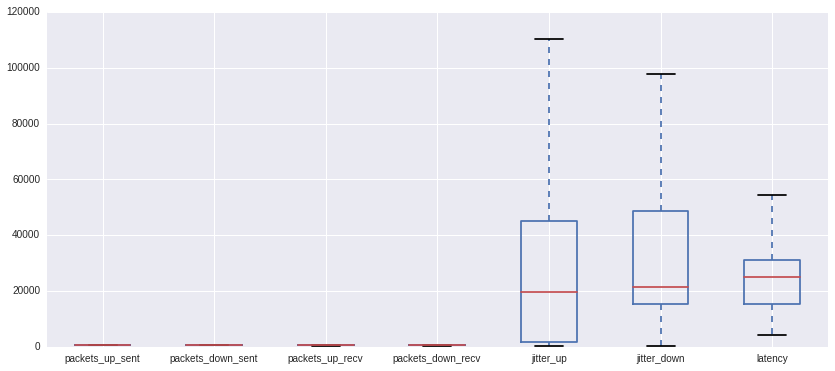

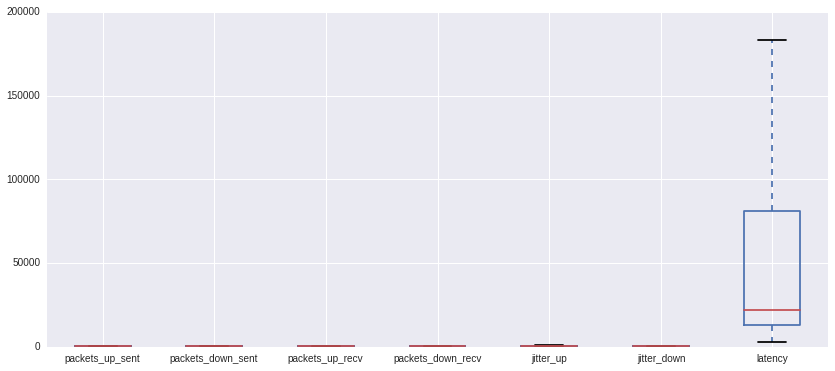

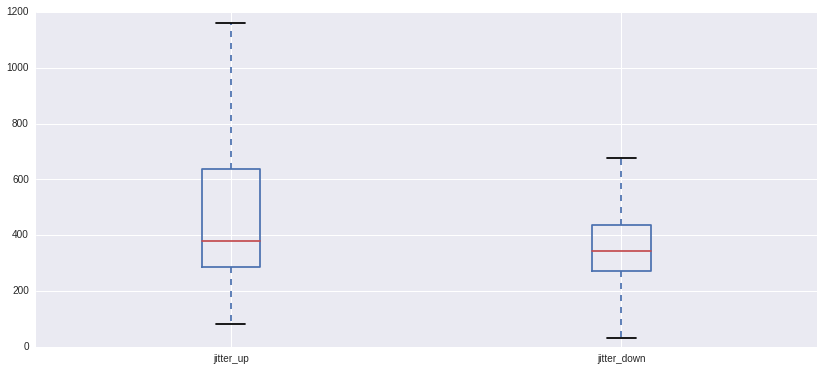

In [568]:
j = fails [ fails['packets_down_sent'] > 0 ]
#success = X[X['s'] == 1]
j.sort(['unit_id','target'])[dtf.cols_UDP_net_stats]

v = j[dtf.cols_UDP_net_stats]#.drop(['jitter_up', 'jitter_down', 'latency'], axis=1)

_ = v.boxplot(sym='')
plt.figure()
_ = success[dtf.cols_UDP_net_stats].boxplot(sym='')
X.corr(method='spearman')

plt.figure()
_ = success[['jitter_up', 'jitter_down']].boxplot(sym='')
#X.corr(method='spearman')

In [562]:
l =  success['latency']
k =  j['latency']

print len(j), len(np.unique(j['unit_id'])), len(np.unique(fails['unit_id']))

1861 218 490


In [561]:
plt.close("All")

In [564]:
X

,unit_id,dtime,day,hour,minute,target,packet_size,stream_rate,duration,packets_up_sent,...,jitter_up,jitter_down,latency,successes,failures,location_id,ranNode,apNode,hubType,headlineSpeed
369301,156280,1396303202,1,0,0,81.147.49.140,160,64000,10043048,500,...,184,152,6186,1,0,224555,1,6,9,4
431937,33282,1396303202,1,0,0,173.234.235.106,160,64000,10044129,500,...,307,215,93009,1,0,60180,1,9,5,4
135542,484532,1396303203,1,0,0,81.147.49.140,160,64000,0,0,...,0,0,0,0,1,631016,5,7,9,2
365684,165816,1396303203,1,0,0,81.147.49.140,160,64000,10044338,500,...,445,357,27259,1,0,326861,5,8,9,2
86698,185740,1396303204,1,0,0,81.147.49.141,160,64000,10046016,500,...,187,181,10999,1,0,295039,6,18,11,4
441287,33033,1396303204,1,0,0,77.75.104.26,160,64000,10043811,500,...,651,256,27575,1,0,223877,1,9,10,4
87978,185794,1396303205,1,0,0,81.147.49.140,160,64000,10044448,500,...,486,357,24633,1,0,288297,NaN,NaN,NaN,NaN
152738,192636,1396303206,1,0,0,81.147.49.141,160,64000,10046695,500,...,484,371,11909,1,0,287691,6,18,8,2
365862,167848,1396303206,1,0,0,81.147.49.141,160,64000,10044421,500,...,710,480,30034,1,0,647106,6,13,9,2
418639,121000,1396303206,1,0,0,81.147.49.140,160,64000,10044840,500,...,320,271,17907,1,0,227899,5,11,9,4


In [19]:
ls ../data/

httpget-H1april2014/


In [20]:
ls ../data/httpget-H1april2014/


httpget-H1april2014.csv  metadata-anon.xlsx         udpjitter-H2april2014.csv
httpget-H1march2014.csv  probes_on_a_trial.csv      udpjitter-H2march2014.csv
httpget-H2april2014.csv  udpjitter-H1april2014.csv
httpget-H2march2014.csv  udpjitter-H1march2014.csv


In [183]:
Y.describe()

,UNIT_ID,PACKET_SIZE,STREAM_RATE,DURATION,PACKETS_UP_SENT,PACKETS_DOWN_SENT,PACKETS_UP_RECV,PACKETS_DOWN_RECV,JITTER_UP,JITTER_DOWN,LATENCY,SUCCESSES,FAILURES,LOCATION_ID
count,3118963.000000,3118963,3118963.000000,3.118963e+06,3118963.000000,3118963.000000,3118963.000000,3118963.000000,3.118963e+06,3118963.000000,3118963.000000,3118963.000000,3118963.000000,3118963.000000
mean,168633.291886,160,63931.623427,9.932479e+06,493.520763,493.266191,493.281976,493.358021,7.108006e+05,819.136490,39345.619142,0.986006,0.013994,358721.178707
std,101128.321441,0,2090.254626,3.177485e+06,56.547670,57.632987,56.653839,56.593670,3.145364e+07,8432.344352,55928.365168,0.117466,0.117466,154370.929963
min,14847.000000,160,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,41307.000000
25%,123830.000000,160,64000.000000,1.004365e+07,500.000000,500.000000,500.000000,500.000000,2.850000e+02,270.000000,12100.000000,1.000000,0.000000,234559.000000
50%,149600.000000,160,64000.000000,1.004465e+07,500.000000,500.000000,500.000000,500.000000,3.770000e+02,342.000000,21094.000000,1.000000,0.000000,289483.000000
75%,185770.000000,160,64000.000000,1.004557e+07,500.000000,500.000000,500.000000,500.000000,6.280000e+02,430.000000,76472.000000,1.000000,0.000000,502551.000000
max,484530.000000,160,64000.000000,5.055337e+08,500.000000,500.000000,737.000000,500.000000,1.394928e+09,5513577.000000,10859879.000000,1.000000,1.000000,631014.000000


/root/.virtualenvs/scipy/local/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


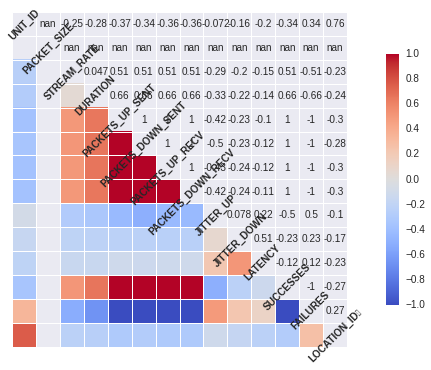

In [29]:
sns.corrplot(Y.corr())

In [28]:
np.corrcoef(Y['JITTER_UP'], Y['JITTER_DOWN'])

array([[ 1.        ,  0.06139573],
       [ 0.06139573,  1.        ]])

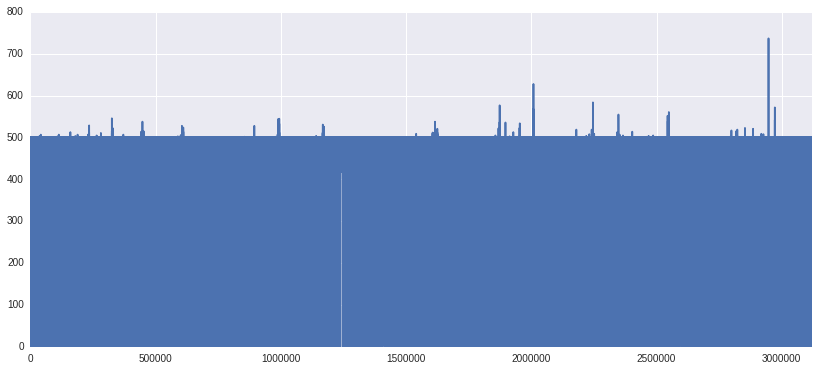

In [27]:
Y['PACKETS_UP_RECV'].plot()

In [31]:
len(np.unique(Y['UNIT_ID']))

2658

In [184]:
pairs = Y.groupby(['UNIT_ID', 'LOCATION_ID\r'])

In [185]:
pairs.describe()

DURATION     FAILURES   JITTER_DOWN  \
UNIT_ID LOCATION_ID\r                                                     
14847   225111        count      1332.000000  1332.000000   1332.000000   
                      mean   10052581.489489     0.000000    452.822823   
                      std       18304.969512     0.000000    390.578296   
                      min    10041796.000000     0.000000    302.000000   
                      25%    10043412.500000     0.000000    371.750000   
                      50%    10044140.000000     0.000000    404.000000   
                      75%    10045026.750000     0.000000    450.000000   
                      max    10134334.000000     0.000000   8745.000000   
14849   224965        count      1344.000000  1344.000000   1344.000000   
                      mean   10045315.376488     0.002232    356.366815   
                      std        3786.674169     0.047210    379.478617   
                      min    10029617.000000     0.000000    189.000000   
                      25%    10043990.500000     0.000000    266.000000   
                      50%    10044979.000000     0.000000    299.500000   
                      75%    10046606.500000     0.000000    333.000000   
                      max    10134630.000000     1.000000   7205.000000   
14871   60313         count      1326.000000  1326.000000   1326.000000   
                      mean   10047742.247360     0.000000    851.651584   
                      std       12713.489857     0.000000   3440.774110   
                      min    10042123.000000     0.000000    303.000000   
                      25%    10043465.000000     0.000000    365.000000   
                      50%    10044183.000000     0.000000    382.000000   
                      75%    10044882.750000     0.000000    404.000000   
                      max    10140499.000000     0.000000  61224.000000   
14924   558017        count      1326.000000  1326.000000   1326.000000   
                      mean   10064270.009050     0.001508    434.413273   
                      std      277555.368348     0.038822    491.983330   
                      min           0.000000     0.000000      0.000000   
                      25%    10044485.250000     0.000000    323.000000   
                      50%    10084694.000000     0.000000    369.000000   
...                                      ...          ...           ...   
482136  626300        std         555.987033     0.000000   1001.571479   
                      min    10036894.000000     0.000000    251.000000   
                      25%    10037844.000000     0.000000    308.000000   
                      50%    10038210.000000     0.000000    323.000000   
                      75%    10038644.000000     0.000000    349.000000   
                      max    10040318.000000     0.000000  11308.000000   
484526  631010        count        39.000000    39.000000     39.000000   
                      mean   10038409.410256     0.000000   1068.282051   
                      std         536.024879     0.000000   2338.951485   
                      min    10037265.000000     0.000000    290.000000   
                      25%    10038083.500000     0.000000    314.000000   
                      50%    10038402.000000     0.000000    332.000000   
                      75%    10038691.500000     0.000000    451.500000   
                      max    10039860.000000     0.000000  13754.000000   
484528  631012        count        40.000000    40.000000     40.000000   
                      mean   10038632.400000     0.000000   1047.250000   
                      std         781.586774     0.000000    920.712426   
                      min    10037472.000000     0.000000    414.000000   
                      25%    10037973.750000     0.000000    468.000000   
                      50%    10038604.000000     0.000000    605.500000   
                      75%    10039215.250000     0.000000   1

In [47]:
X.describe()

,UNIT_ID,FETCH_TIME,BYTES_TOTAL,BYTES_SEC,BYTES_SEC_INTERVAL,WARMUP_TIME,WARMUP_BYTES,SEQUENCE,THREADS,SUCCESSES,FAILURES,LOCATION_ID
count,3158781.000000,3158781.000000,3.158781e+06,3158781.000000,3158781.000000,3.158781e+06,3.158781e+06,3158781,3158781,3158781.000000,3158781.000000,3158781.000000
mean,168542.216217,5793641.217798,1.446276e+07,3991598.748337,3991598.748337,9.207629e+05,1.954718e+06,0,1,0.985385,0.014615,358544.378082
std,101294.697834,4509895.007399,1.565673e+07,3415197.875182,3415197.875182,2.132767e+06,5.143761e+06,0,0,0.120006,0.120006,154436.125659
min,14847.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0,1,0.000000,0.000000,41307.000000
25%,123820.000000,2471218.000000,8.484060e+06,845920.000000,845920.000000,3.515880e+05,5.252220e+05,0,1,1.000000,0.000000,234559.000000
50%,149598.000000,4089889.000000,9.438000e+06,3608157.000000,3608157.000000,5.302490e+05,5.252470e+05,0,1,1.000000,0.000000,289461.000000
75%,185770.000000,10000300.000000,2.202103e+07,6822893.000000,6822893.000000,1.032698e+06,3.146106e+06,0,1,1.000000,0.000000,502549.000000
max,484530.000000,34802542.000000,3.874781e+08,38818040.000000,38818040.000000,6.155360e+08,1.890602e+08,0,1,1.000000,1.000000,631014.000000


In [48]:
Y.describe()

,UNIT_ID,PACKET_SIZE,STREAM_RATE,DURATION,PACKETS_UP_SENT,PACKETS_DOWN_SENT,PACKETS_UP_RECV,PACKETS_DOWN_RECV,JITTER_UP,JITTER_DOWN,LATENCY,SUCCESSES,FAILURES,LOCATION_ID
count,3118963.000000,3118963,3118963.000000,3.118963e+06,3118963.000000,3118963.000000,3118963.000000,3118963.000000,3.118963e+06,3118963.000000,3118963.000000,3118963.000000,3118963.000000,3118963.000000
mean,168633.291886,160,63931.623427,9.932479e+06,493.520763,493.266191,493.281976,493.358021,7.108006e+05,819.136490,39345.619142,0.986006,0.013994,358721.178707
std,101128.321441,0,2090.254626,3.177485e+06,56.547670,57.632987,56.653839,56.593670,3.145364e+07,8432.344352,55928.365168,0.117466,0.117466,154370.929963
min,14847.000000,160,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,41307.000000
25%,123830.000000,160,64000.000000,1.004365e+07,500.000000,500.000000,500.000000,500.000000,2.850000e+02,270.000000,12100.000000,1.000000,0.000000,234559.000000
50%,149600.000000,160,64000.000000,1.004465e+07,500.000000,500.000000,500.000000,500.000000,3.770000e+02,342.000000,21094.000000,1.000000,0.000000,289483.000000
75%,185770.000000,160,64000.000000,1.004557e+07,500.000000,500.000000,500.000000,500.000000,6.280000e+02,430.000000,76472.000000,1.000000,0.000000,502551.000000
max,484530.000000,160,64000.000000,5.055337e+08,500.000000,500.000000,737.000000,500.000000,1.394928e+09,5513577.000000,10859879.000000,1.000000,1.000000,631014.000000


In [57]:
list(X.columns)

['UNIT_ID',
 'DTIME',
 'TARGET',
 'ADDRESS',
 'FETCH_TIME',
 'BYTES_TOTAL',
 'BYTES_SEC',
 'BYTES_SEC_INTERVAL',
 'WARMUP_TIME',
 'WARMUP_BYTES',
 'SEQUENCE',
 'THREADS',
 'SUCCESSES',
 'FAILURES',
 'LOCATION_ID\r']

In [58]:
list(Y.columns)

['UNIT_ID',
 'DTIME',
 'TARGET',
 'PACKET_SIZE',
 'STREAM_RATE',
 'DURATION',
 'PACKETS_UP_SENT',
 'PACKETS_DOWN_SENT',
 'PACKETS_UP_RECV',
 'PACKETS_DOWN_RECV',
 'JITTER_UP',
 'JITTER_DOWN',
 'LATENCY',
 'SUCCESSES',
 'FAILURES',
 'LOCATION_ID\r']

In [59]:
X['TARGET'].head(5)

0    http://n3-btretail-uk.samknows.com
1           http://n1-the1.samknows.com
2           http://n2-the1.samknows.com
3     http://n2-newyork-us.samknows.com
4     http://n4-newyork-us.samknows.com
Name: TARGET, dtype: object

In [60]:
Y['TARGET'].head(5)

0    n3-btretail-uk.samknows.com
1    n4-btretail-uk.samknows.com
2           n4-the1.samknows.com
3     n3-newyork-us.samknows.com
4    n3-btretail-uk.samknows.com
Name: TARGET, dtype: object

In [61]:
X['ADDRESS'].head(5)

0      213.120.179.1
1       46.17.56.234
2       46.17.56.235
3     108.62.233.154
4    173.234.235.106
Name: ADDRESS, dtype: object

0    121324
1    123790
2     32956
3    120562
4    121174
Name: UNIT_ID, dtype: int64

In [66]:
fcodes = '../data/httpget-H1april2014/httpget-H1march2014_hashed_and_codes.csv'

In [67]:
Xcodes = pd.read_csv(fcodes,
                header=0,
                delimiter=r',',
                #date_parser=fromtimestamp,
                #parse_dates=["ts_start", "ts_end"],
                #encoding='latin-1',
                #converters={"cookieName": tohash},
                 lineterminator="\n",
                skipinitialspace=True)

In [69]:
np.unique(Xcodes['ADDRESS'])

/root/.virtualenvs/scipy/local/lib/python2.7/site-packages/numpy/lib/arraysetops.py:198: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


array([nan, 'AU', 'GB', 'US'], dtype=object)

In [70]:
Xcodes['ADDRESS'].describe()

count     3153203
unique          3
top            GB
freq      2362416
Name: ADDRESS, dtype: object

In [71]:
Xcodes.groupby(['ADDRESS']).describe()

BYTES_SEC  BYTES_SEC_INTERVAL   BYTES_TOTAL  \
ADDRESS                                                            
AU      count      1562.000000         1562.000000  1.562000e+03   
        mean          0.000000            0.000000  0.000000e+00   
        std           0.000000            0.000000  0.000000e+00   
        min           0.000000            0.000000  0.000000e+00   
        25%           0.000000            0.000000  0.000000e+00   
        50%           0.000000            0.000000  0.000000e+00   
        75%           0.000000            0.000000  0.000000e+00   
        max           0.000000            0.000000  0.000000e+00   
GB      count   2362416.000000      2362416.000000  2.362416e+06   
        mean    4563992.200184      4563992.200184  1.504376e+07   
        std     3622661.572020      3622661.572020  1.720499e+07   
        min           0.000000            0.000000  0.000000e+00   
        25%      902118.750000       902118.750000  8.669480e+06   
        50%     4458479.500000      4458479.500000  9.438000e+06   
        75%     7873371.500000      7873371.500000  2.202103e+07   
        max    38818040.000000     38818040.000000  3.874781e+08   
US      count    789225.000000       789225.000000  7.892250e+05   
        mean    2314343.930162      2314343.930162  1.285447e+07   
        std     1860237.679795      1860237.679795  9.463863e+06   
        min           0.000000            0.000000  0.000000e+00   
        25%      655663.000000       655663.000000  7.092680e+06   
        50%     1828558.000000      1828558.000000  9.438000e+06   
        75%     4005518.000000      4005518.000000  2.202060e+07   
        max    38295028.000000     38295028.000000  3.829594e+08   

                     FAILURES       FETCH_TIME     LOCATION_ID  SEQUENCE  \
ADDRESS                                                                    
AU      count     1562.000000      1562.000000     1562.000000      1562   
        mean         1.000000         0.000000   376801.565301         0   
        std          0.000000         0.000000   164678.060622         0   
        min          1.000000         0.000000    59722.000000         0   
        25%          1.000000         0.000000   246346.000000         0   
        50%          1.000000         0.000000   326905.000000         0   
        75%          1.000000         0.000000   557899.000000         0   
        max          1.000000         0.000000   627656.000000         0   
GB      count  2362416.000000   2362416.000000  2362416.000000   2362416   
        mean         0.015452   4965232.167989   358455.489015         0   
        std          0.123342   3406074.135420   154379.514172         0   
        min          0.000000         0.000000    41307.000000         0   
        25%          0.000000   2409003.750000   234559.000000         0   
        50%          0.000000   3087990.000000   289449.000000         0   
        75%          0.000000  10000066.000000   502541.000000         0   
        max          1.000000  31027988.000000   631014.000000         0   
US      count   789225.000000    789225.000000   789225.000000    789225   
        mean         0.003196   8325762.465998   358727.755008         0   
        std          0.056439   6157019.395114   154444.781134         0   
        min          0.000000         0.000000    41307.000000         0   
        25%          0.000000   4691168.000000   234573.000000         0   
        50%          0.000000   7107503.000000   289483.000000         0   
        75%          0.000000  10001541.000000   502559.000000         0   
        max          1.000000  34802542.000000   631014.000000         0   

                    SUCCESSES          TARGET  THREADS         UNIT_ID  \
ADDRESS                                                                  
AU      count     1562.000000     1562.000000     1562     1562.000000   
        mean         0.000000        9.074264        

In [571]:
X.columns

Index([u'unit_id', u'dtime', u'day', u'hour', u'minute', u'target',
       u'packet_size', u'stream_rate', u'duration', u'packets_up_sent',
       u'packets_down_sent', u'packets_up_recv', u'packets_down_recv',
       u'jitter_up', u'jitter_down', u'latency', u'successes', u'failures',
       u'location_id', u'ranNode', u'apNode', u'hubType', u'headlineSpeed'],
      dtype='object')

In [574]:
Y = X.sort(['unit_id', 'dtime'], ascending=[1,1])

In [637]:
zscore = lambda x: (x - x.mean()) / x.std()
 
grps = Y.groupby(['unit_id']) 

grps_dict = dict(list( grps ))

jitz = grps[['jitter_up', 'jitter_down']].transform(zscore)


In [638]:
jitz 
#grps[488790] [['jitter_up', 'jitter_down']]
#k = j.groups.keys()
#l= j.get_group(k[3])

#k[0]
#j.head(2)

#Y[['jitter_up', 'jitter_down']].corr?

,jitter_up,jitter_down
416044,-0.235651,-0.134877
416045,-0.253146,-0.200508
416046,-0.305631,-0.286866
416047,-0.259707,-0.233324
416048,4.232155,6.846273
416049,-0.353743,-0.257504
416050,-0.364677,-0.219507
416051,-0.218156,-0.231597
416052,6.908902,5.348832
416053,-0.277202,-0.190146


In [635]:
zscore = lambda x: (x - x.mean()) / x.std()

j = Y[['jitter_up', 'jitter_down']]
j.corr(method='spearman')

,jitter_up,jitter_down
jitter_up,1.000000,0.717096
jitter_down,0.717096,1.000000


In [ ]:
Y[['jitter_up', 'jitter_down']].corr

In [ ]:
#print grps
#l[['jitter_up', 'jitter_down']].plot( lw=3, alpha=.4)